In [59]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

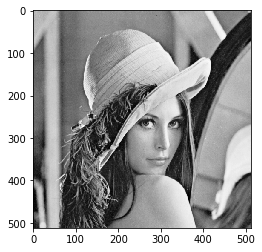

In [367]:
#read original image
img = cv2.imread("./Lab2_JPEG/lena_512.bmp")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #COLOR_BGR2YCR_CB
plt.imshow(img, cmap="Greys_r")

In [368]:
#Quality Factor, we can tweek these
QF1 = 60
QF2 = 80

Q50 = np.array([[16,11,10,16,24,40,51,61],[12,12,14,19,26,58,60,55],[14,13,16,24,40,57,69,56],[14,17,22,29,51,87,80,62],[18,22,37,56,68,109,103,77],[24,35,55,64,81,104,113,92],[49,64,78,87,103,121,120,101],[72,92,95,98,112,100,103,99]])
print(Q50)

[[ 16  11  10  16  24  40  51  61]
 [ 12  12  14  19  26  58  60  55]
 [ 14  13  16  24  40  57  69  56]
 [ 14  17  22  29  51  87  80  62]
 [ 18  22  37  56  68 109 103  77]
 [ 24  35  55  64  81 104 113  92]
 [ 49  64  78  87 103 121 120 101]
 [ 72  92  95  98 112 100 103  99]]


In [369]:
#Quality Matrix for QF1
if QF1 > 50:
    QM1 = np.around(Q50*(np.ones(Q50.shape,dtype=int)*((100-QF1)/50)))
    QM1.astype(int)

elif QF1 < 50:
    QM1 = np.around(Q50*(np.ones(Q50.shape,dtype=int)*(50/QF1)))
    QM1.astype(int)

elif QF1 == 50:
    QM1 = Q50
    
else:
    print("error")

QM1.astype(float)

array([[13.,  9.,  8., 13., 19., 32., 41., 49.],
       [10., 10., 11., 15., 21., 46., 48., 44.],
       [11., 10., 13., 19., 32., 46., 55., 45.],
       [11., 14., 18., 23., 41., 70., 64., 50.],
       [14., 18., 30., 45., 54., 87., 82., 62.],
       [19., 28., 44., 51., 65., 83., 90., 74.],
       [39., 51., 62., 70., 82., 97., 96., 81.],
       [58., 74., 76., 78., 90., 80., 82., 79.]])

In [370]:
#Quality Matrix for QF2
if QF2 > 50:
    QM2 = np.around(Q50*(np.ones(Q50.shape,dtype=int)*((100-QF2)/50)))
    QM2.astype(int)

elif QF2 < 50:
    QM2 = np.around(Q50*(np.ones(Q50.shape,dtype=int)*(50/QF2)))
    QM2.astype(int)

elif QF2 == 50:
    QM2 = Q50
    
else:
    print("error")

QM2.astype(float)

array([[ 6.,  4.,  4.,  6., 10., 16., 20., 24.],
       [ 5.,  5.,  6.,  8., 10., 23., 24., 22.],
       [ 6.,  5.,  6., 10., 16., 23., 28., 22.],
       [ 6.,  7.,  9., 12., 20., 35., 32., 25.],
       [ 7.,  9., 15., 22., 27., 44., 41., 31.],
       [10., 14., 22., 26., 32., 42., 45., 37.],
       [20., 26., 31., 35., 41., 48., 48., 40.],
       [29., 37., 38., 39., 45., 40., 41., 40.]])

In [371]:
#DCT domain
dct_domain = np.zeros(img.shape) #should just be same shape
dct_quantized = np.zeros(img.shape)
dct_dequantized = np.zeros(img.shape)
dct_restored = np.zeros(img.shape)

dct_domain2 = np.zeros(img.shape)
dct_quantized2 = np.zeros(img.shape)

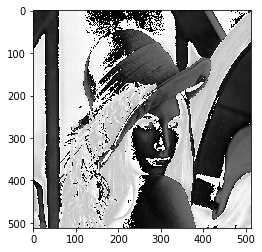

In [372]:
#Subtract each img value by 128
img2 = img - 128
plt.imshow(img2, cmap="Greys_r")

In [376]:
#JPEG Encoding

for i in range(0, img.shape[0], 8): #row 8x8
    
    for j in range(0, img.shape[1], 8):
        
        block = img2[i:i+8,j:j+8] #set the block
        win1 = dct(dct(block, axis=0, norm='ortho'), axis=1, norm="ortho")
        dct_domain[i:i+8,j:j+8] = win1
        
        win2 = np.around(win1/QM1)
        dct_quantized[i:i+8,j:j+8] = win2

In [377]:
#JPEG Decoding

for i in range(0, img.shape[0], 8):
    
    for j in range(0, img.shape[1], 8):
        
        win2 = dct_quantized[i:i+8, j:j+8]
        win3 = win2*QM1 #dequantization of DCT coeff
        dct_dequantized[i:i+8, j:j+8] = win3       
        win4 = dct(dct(win3, axis=0, norm='ortho'), axis=1, norm="ortho")
        dct_restored[i:i+8, j:j+8] = win4
        

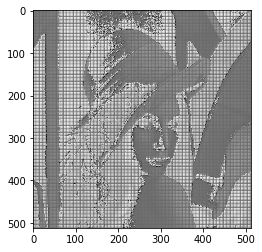

In [378]:
#img reconstruction?
img2_recon = dct_restored

plt.imshow(img2_recon+128, cmap="Greys_r") #sanity check on recon image

In [365]:
#JPEG Encoding 2

for i in range(0, img.shape[0], 8): #row 8x8
    
    for j in range(0, img.shape[1], 8):
        
        block = img2_recon[i:i+8,j:j+8] #set the block
        win5 = dct(block,1)
        dct_domain2[i:i+8,j:j+8] = win5
        
        win6 = np.around(win5/QM2)
        dct_quantized2[i:i+8,j:j+8] = win2

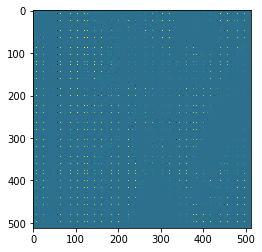

In [353]:
plt.imshow(dct_quantized) #DCT 1st quant

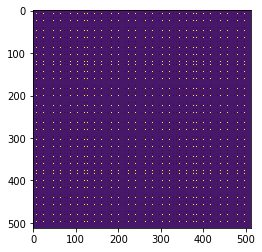

In [354]:
plt.imshow(dct_quantized2) #DCT 2nd quant

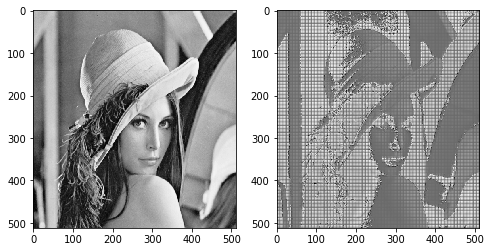

In [355]:
#both image and recon image side by side
f, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow(img, cmap="Greys_r", aspect="auto")
ax[1].imshow(img2_recon+128, cmap="Greys_r", aspect="auto")

# need to do the histogram
# we might need to do YCrCb?
# make comments regarding changing qualify factor?